# NATURAL LANGUAGE PROCESSING PROJECT 2024/2025
---
## Named Entity Recognition – Zero-Shot Approaches

**Zoren Martinez 2123873 (Computer Engineering, AI and Robotics)**
<br>
**Eddie Carraro 2121248 (Computer Engineering, AI and Robotics)**

In this project, we implement and evaluate zero-shot methods for Named Entity Recognition (NER), based on the study by Xie et al. (2023): "An Empirical Study of Zero-Shot NER with ChatGPT". [https://arxiv.org/abs/2310.10035](https://arxiv.org/abs/2310.10035)
<br>
In addition to reproducing the baseline method proposed in the paper, we also design and test two additional zero-shot methods inspired by the same study.

The dataset used for the experiments is available at:
https://huggingface.co/datasets/tner/conll2003

The model used is meta-llama/Llama-3.3-70B-Instruct-Turbo-Free via the together.ai API.

---

#Imports and API Setup

In [143]:
!pip install -U datasets
!pip install evaluate
!pip install -q together

# Used to parse the response of the model in json format
import json
import re
import unicodedata

# Used to load the dataset
from datasets import load_dataset

# Used in order to avoid APIs request limit
import time

# Used to generate POS Tags
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Used for Evaluation part
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Imports to use Together.ai APIs
from together import Together

#INSERT HERE YOU API FROM together.ai
together_api_key = ""

client = Together(api_key=together_api_key)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


#Import dataset
CoNLL-2003 NER dataset formatted in a part of [TNER](https://github.com/asahi417/tner) project.



In [144]:
# Dataset
dataset = load_dataset("tner/conll2003")

entities = ['Organization', 'Miscellaneous', 'Person', 'Location']

feature_names = {
        "B-ORG": 1, "B-MISC": 2, "B-PER": 3, "I-PER": 4,
        "B-LOC": 5, "I-ORG": 6, "I-MISC": 7, "I-LOC": 8   # We removed ' "O": 0 ' in order to let the model generate shorter responses
    }

# Global variables

In [145]:
# Number of the examples to be taken from the train set
TEST_SIZE = 50

# Model used
MODEL= "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"

# Used in order not to terminate the max number of model calls per minute
TIME_SLEEP = 3

test_dataset = dataset["test"]

#Helper functions

**modelRequest** function is used to make a model call. In particular, we use a client to make an API call to a model from the *together.ai* site.

In [146]:
def modelRequest(prompt, messages):

    max_wait = 60  # max wait time in seconds
    wait_time = 1  # initial wait time

    while True:
        try:
            messages.append({
                    "role": "user", "content": prompt})

            response = client.chat.completions.create(
                          model= MODEL,
                          messages= messages
                      )

            return response.choices[0].message.content

        except Exception as e:
            # Check if error is rate limit error by error message or code
            if hasattr(e, "code") and e.code == 429:
                print(f"[429] Rate limit exceeded. Waiting {wait_time} seconds before retrying...")
                time.sleep(wait_time)
                wait_time = min(wait_time * 2, max_wait)
            else:
                print(f"[Fatal] Unexpected error: {e}")
                raise


In [147]:
def clean_invisible_chars(s):
    # Function to remove characters that could have problems with json parsing
    return ''.join(c for c in s if c.isprintable() or c in '\r\n\t')

def extract_json(text):
    text = clean_invisible_chars(text.strip())
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        pass

    start = text.find('{')
    end = text.rfind('}')
    if start != -1 and end != -1 and end > start:
        json_str = text[start:end+1]
        try:
            return json.loads(clean_invisible_chars(json_str))
        except json.JSONDecodeError as e:
            raise ValueError(f"JSON parsing error inside extracted block: {e}")

    raise ValueError("No valid JSON block found")


**EVALUATION PART**

**evaluate_ner** returns the performance of a specific method given the predicted tags (the gold tags are computed in the function itself).

In [148]:
def evaluate_ner(pred):
    gold = test_dataset["tags"][:TEST_SIZE]

    if len(gold) != len(pred):
        raise ValueError("Gold and pred list with different sizes.")

    gold_labels = [item for sublist in gold for item in sublist]
    pred_labels = [item for sublist in pred for item in sublist]

    accuracy = accuracy_score(gold_labels, pred_labels)
    report = classification_report(gold_labels, pred_labels, digits=3, zero_division=0)

    print(f"Token-Level Accuracy: {accuracy:.3f}\n")
    print("Classification Report (token-level):\n")
    print(report)

    labels = sorted(set(gold_labels + pred_labels))
    cm = confusion_matrix(gold_labels, pred_labels, labels=labels)

    id2label = {v: k for k, v in feature_names.items()}

    label_names = [id2label.get(l, str(l)) for l in labels]

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (token-level)")
    plt.tight_layout()
    plt.show()


**predicted_tags_for_evaluation** returns the predicted tags for the methods from the paper, given the JSON file.

In [180]:
def predicted_tags_for_evaluation(json_file):
  predicted_tags = []

  with open(json_file, "r") as f:
      data = f.read()

  # Convert the string representation of the list of dictionaries into actual Python objects
  lists_of_dictionaries = ast.literal_eval(data)

  # Used to keep track of our current index across the list of dictionaries
  accummulated_list_index = 0


  for current_phrase_position in range(TEST_SIZE):

    current_phrase = test_dataset["tokens"][current_phrase_position]

    # A temporary list to store all label dictionaries for the current sentence
    whole_current_list = []

    # Default labels for the current sentences (all zeros)
    predicted_tags_for_single_sentence = [0] * len(current_phrase)

    try:

      # Case in which we are NOT applying the Vanilla Model, so we want to merge the lists for the len(ordered_labels_list) labels
      if len(lists_of_dictionaries) != TEST_SIZE:
        for label_index in range(len(ordered_labels_list)):
          current_list = ast.literal_eval(lists_of_dictionaries[label_index + accummulated_list_index])

          # Add all the dictionaries in the current label list to the combined list
          if current_list:
            for dictionary in current_list:
              whole_current_list.append(dictionary)

        # Move forward in the list of dictionaries by the number of labels
        accummulated_list_index += len(ordered_labels_list)

      # In the other cases...
      else:
        whole_current_list = ast.literal_eval(lists_of_dictionaries[accummulated_list_index])
        accummulated_list_index += 1

      # If there are no labels for this sentence, use an empty dictionary
      if not whole_current_list:
        current_dictionary = {}
      else:

        for current_dictionary in whole_current_list:
          for character_in_phrase in range(len(current_phrase)):
            if current_phrase[character_in_phrase] in current_dictionary:
              predicted_tags_for_single_sentence[character_in_phrase] = feature_names.get(current_dictionary[current_phrase[character_in_phrase]])

    # If there's a syntax error while parsing the dictionary, mark the sentence with -1s (which consists of a non-valid label)
    except SyntaxError:

      predicted_tags_for_single_sentence = [-1] * (len(current_phrase))

      if len(lists_of_dictionaries) != TEST_SIZE:

        #We need to skip the lists to use yet regarding the bad-parsed sentence
        lists_to_skip = len(ordered_labels_list) - label_index
        accummulated_list_index += lists_to_skip

      else:

        accummulated_list_index += 1



    predicted_tags.append(predicted_tags_for_single_sentence)

  return predicted_tags

#Methods from the paper

The following function is used to generate the prompt we need, based on the task we want to accomplish (0 stands for "Vanilla" Method, other values are good for all the other tasks). We divided it in two in order to use less computation during the execution, as the entire conversation is passed to the model in each iteration anyway, so it has access to the first part of the prompt itself.

In [150]:
def createPrompt(task, tokens_list, pos_tags_list, label_order_position):

  if label_order_position == 0:

    indexed_labels = [f"{i} = '{label}'" for label, i in feature_names.items()]
    indexed_labels_str = "\n".join(indexed_labels)

    explanation = (
        "ORG = Organization\n"
        +"PER = Person\n"
        +"LOC = Location\n"
        +"MISC = Miscellaneous entity\n"
    )

    label_names = (
        "Given the following entity label set: "
        + ordered_labels
        + "\nand the following BIO tags with the relative indexes:\n"
        + indexed_labels_str
        + "\nwhich are explained by the following explanation:\n"
        + explanation
    )

    if pos_tags_list != []:
      pos_tags = ' '.join([str(s) for s in pos_tags_list])
      pos_tags_str = (
          "\nGiven the POS tags set: "
          + pos_tags
          + "\n"
      )
      label_names = label_names + pos_tags_str

    prompt = (
        label_names
        + "\nPlease recognize the named entities in the given text.\n"
        + "Text: "
        + str(tokens_list)
    )

    if task != 0:   # If the Method is NOT the Vanilla one...
      prompt = (
        prompt
        + "'\nQuestion: What are the named entities labeled as '" + ordered_labels_list[0] + "' in the text? "
      )

  else:
    prompt = (
      "\nQuestion: Considering the assigned labels in the previously given responses, what are the named entities labeled as '" + ordered_labels_list[label_order_position] + "' in the text? "
      + "Do NOT re-label words which you already labelled on the previous questions."
    )

  prompt = (
      prompt
      + "\nProvide the entities in the following JSON format: [{'Token_1': 'Label_1'}, ..., {'Token_i': 'Label_i'}] where Labels are the BIO tags. If no such entities exist, return the following empty list: '[]' ."
      + "\nAnswer only with the final list, without providing explanations or reasoning."
  )

  return prompt

#Label order given by the selected model
As stated in the paper, we need to ask our model to give a reasonable label order based on its understanding of the labels.

In [151]:
prompt_for_labels_ordering = ("Given the label set "
          + str(entities)
          +", give a reasonable order of them in a list.\n"
          + "Answer without providing explanations and providing only the list of ordered labels.\n"
          + "Answer: "
)

ordered_labels = modelRequest(prompt_for_labels_ordering, [])

ordered_labels_list = eval(ordered_labels)

print("Labels order:\n", ordered_labels_list)

Labels order:
 ['Person', 'Organization', 'Location', 'Miscellaneous']


#Vanilla Method
Also called the Baseline Method. With the Vanilla Method it will be asked to the model to detect the labels in the provided sentence with a single call.

**Example of the prompt**:
```
Given the following entity label set:  ['Organization', 'Person', 'Location', 'Miscellaneous']
and the following BIO tags with the relative indexes:
1 = 'B-ORG'
2 = 'B-MISC'
3 = 'B-PER'
4 = 'I-PER'
5 = 'B-LOC'
6 = 'I-ORG'
7 = 'I-MISC'
8 = 'I-LOC'
which are explained by the following explanation:
ORG = Organization
PER = Person
LOC = Location
MISC = Miscellaneous entity

Please recognize the named entities in the given text.
Text: ['Hi', 'my', 'name', 'is', 'Roberto', '.']
Provide the entities in the following JSON format: [{'Token_1': 'Label_1'}, ..., {'Token_i': 'Label_i'}] where Labels are the BIO tags. If no such entities exist, return the following empty list: '[]' .
Answer only with the final list, without providing explanations or reasoning.
```


In [152]:
predicted_tags = []
responses = []

for i in range(TEST_SIZE):

  prompt = createPrompt(0, test_dataset["tokens"][i], [], 0)

  response_raw = modelRequest(prompt,[])  # Messages are not required in Vanilla Method

  time.sleep(TIME_SLEEP)

  # We print only the first one as an example
  if ( i == 0 ):
    print(response_raw)

  responses.append(response_raw)

[{'SOCCER': 'B-MISC'}, {'JAPAN': 'B-LOC'}, {'CHINA': 'B-LOC'}]


In [153]:
json_object = json.dumps(responses)

# Writing to the json file
with open("Vanilla.json", "w") as outfile:
    outfile.write(json_object)

#Basic Decomposed-QA Method
In the Basic Decomposed-QA Method, we will take the Vanilla Method prompt and we will enhance it asking to the model to detect the single labels in different calls.

**Example of the prompt for the first call**:
```
Given the following entity label set:  ['Organization', 'Person', 'Location', 'Miscellaneous']
and the following BIO tags with the relative indexes:
1 = 'B-ORG'
2 = 'B-MISC'
3 = 'B-PER'
4 = 'I-PER'
5 = 'B-LOC'
6 = 'I-ORG'
7 = 'I-MISC'
8 = 'I-LOC'
which are explained by the following explanation:
ORG = Organization
PER = Person
LOC = Location
MISC = Miscellaneous entity

Please recognize the named entities in the given text.
Text: ['Hi', 'my', 'name', 'is', 'Roberto', '.']
Question: What are the named entities labeled as 'Organization' in the text?
Provide the entities in the following JSON format: [{'Token_1': 'Label_1'}, ..., {'Token_i': 'Label_i'}] where Labels are the BIO tags. If no such entities exist, return the following empty list: '[]' .
Answer only with the final list, without providing explanations or reasoning.
```
<br>

**Example of the prompt for the next calls**:
```
Question: Considering the assigned labels in the previously given responses, what are the named entities labeled as 'Person' in the text?  Do NOT re-label words which you already labelled on the previous questions.
Provide the entities in the following JSON format: [{'Token_1': 'Label_1'}, ..., {'Token_i': 'Label_i'}] where Labels are the BIO tags. If no such entities exist, return the following empty list: '[]' .
Answer only with the final list, without providing explanations or reasoning.
```

In [155]:
predicted_tags = []
responses = []

for i in range(TEST_SIZE):

  # Start a new conversation for each sentence
  messages = []

  for label in ordered_labels_list:
    prompt = createPrompt(1, test_dataset["tokens"][i], [], ordered_labels_list.index(label))

    response_raw = modelRequest(prompt,messages)
    time.sleep(TIME_SLEEP)

    if (i==0):
      # Print only the first one as an example
      print(label + ": " + response_raw)


    # Add to messages the response of the model
    messages.append({
            "role": "assistant", "content": response_raw})

    responses.append(response_raw)

Person: []
Organization: []
Location: [{'JAPAN': 'B-LOC'}, {'CHINA': 'B-LOC'}]
Miscellaneous: [{'SOCCER': 'B-MISC'}]


In [156]:
json_object = json.dumps(responses)

# Writing to the json filee
with open("Decomposed_QA.json", "w") as outfile:
    outfile.write(json_object)

#Tool Augmentation Method
In the following part, we will use it to perform the so-called Tool Augmentation. In particular, compared to the Basic Decomposed-QA Method, we will also use POS Tags to detect the labels.

**Example of the prompt for the first call**:
```
Given the following entity label set:  ['Organization', 'Person', 'Location', 'Miscellaneous']
 and the following BIO tags with the relative indexes:
1 = 'B-ORG'
2 = 'B-MISC'
3 = 'B-PER'
4 = 'I-PER'
5 = 'B-LOC'
6 = 'I-ORG'
7 = 'I-MISC'
8 = 'I-LOC'
which are explained by the following explanation:
ORG = Organization
PER = Person
LOC = Location
MISC = Miscellaneous entity

Given the POS tags set: ('Hi', 'NNP') ('my', 'PRP$') ('name', 'NN') ('is', 'VBZ') ('Roberto', 'NNP') ('.', '.')

Please recognize the named entities in the given text.
Text: '['Hi', 'my', 'name', 'is', 'Roberto', '.']'
Question: What are the named entities labeled as 'Organization' in the text?
Provide the entities in the following JSON format: [{'Token_1': 'Label_1'}, ..., {'Token_i': 'Label_i'}] where Labels are the BIO tags. If no such entities exist, return the following empty list: '[]' .
Answer only with the final list, without providing explanations or reasoning.
```
<br>

**Example of the prompt for the next calls**:
```
Question: Considering the assigned labels in the previously given responses, what are the named entities labeled as 'Person' in the text? Do NOT re-label words which you already labelled on the previous questions.
Provide the entities in the following JSON format: [{'Token_1': 'Label_1'}, ..., {'Token_i': 'Label_i'}] where Labels are the BIO tags. If no such entities exist, return the following empty list: '[]' .
Answer only with the list, without providing explanations or reasoning.
```

**POS Tagging**

In [157]:
sentences = [test_dataset["tokens"][i] for i in range(TEST_SIZE)]

pos_tags = []

for sentence_tokens in sentences:
  sentence_str = " ".join(sentence_tokens)  # Join tokens into a single string
  for sent in sent_tokenize(sentence_str):
    wordtokens = word_tokenize(sent)
    pos_tags.append(nltk.pos_tag(wordtokens))

In [158]:
predicted_tags = []
responses = []

for i in range(TEST_SIZE):

  # Start a new conversation for each sentence
  messages = []

  for label in ordered_labels_list:
    prompt = createPrompt(2, test_dataset["tokens"][i], pos_tags[i], ordered_labels_list.index(label))

    response_raw = modelRequest(prompt,messages)
    time.sleep(TIME_SLEEP)

    if (i==0):
      print(label + ": " + response_raw)

    # Add to messages the response of the model
    messages.append({
            "role": "assistant", "content": response_raw})

    responses.append(response_raw)

Person: []
Organization: []
Location: [{'JAPAN': 'B-LOC'}, {'CHINA': 'B-LOC'}]
Miscellaneous: [{'SOCCER': 'B-MISC'}, {'SURPRISE': 'B-MISC'}, {'DEFEAT': 'B-MISC'}, {'LUCKY': 'B-MISC'}, {'WIN': 'B-MISC'}, {'GET': 'B-MISC'}, {'IN': 'B-MISC'}]


In [159]:
json_object = json.dumps(responses)

# Writing to the json file
with open("Tool_Augmentation.json", "w") as outfile:
    outfile.write(json_object)

#Our Method

# Multi-Agent Prompting for Named Entity Recognition (NER)

The new method we came up for Named Entity Recognition (NER) implements a multi-agent prompting architecture. Each agent operates with a specific objective to maximize interpretability in entity annotation:

- ## Reasoner
Performs initial NER tagging and provides detailed justifications for each label. Its output aims to make the underlying reasoning explicit and traceable.
- ## Critic
Evaluates the logical coherence between the input text and the Reasoner's explanation. It identifies inconsistencies, fallacies, omissions, or overgeneralizations in the reasoning process.
- ## Arbiter
Acts as a final decision-maker. It reviews both the Reasoner's and Critic's outputs, adjudicates disagreements, and determines whether to accept or reject the proposed annotations.

This multi-agent configuration allows the system to simulate a structured peer-review process, ensuring that the generated labels are not only plausible but also clearly justified and critically examined.

## Prompt for the Reasoner

**Example of the prompt**:
```
Given the following entity label set:
B-ORG, B-MISC, B-PER, I-PER, B-LOC, I-ORG, I-MISC, I-LOC, O

You are a Named Entity Recognition (NER) expert.
Your task is to extract all named entities from the input sentence.
For each extracted entity, explain why you assigned that label, based on the linguistic or contextual cues in the sentence.
Be as explicit and structured as possible in your reasoning.

Input sentence:
['Hi', 'my', 'name', 'is', 'Roberto', '.']

```

In [160]:
def reasonerPrompt(tokens_list):
    ordered_labels = list(feature_names.keys())

    label_names = (
        "Given the following entity label set:\n"
        + ", ".join(ordered_labels) + "\n\n"
    )

    num_tokens = len(tokens_list)
    tokens_repr = str(tokens_list)

    prompt = (
        label_names
        + "You are a Named Entity Recognition (NER) expert.\n"
        + "Your task is to extract all named entities from the input sentence.\n"
        + "For each extracted entity, explain why you assigned that label, based on the linguistic or contextual cues in the sentence.\n"
        + "Be as explicit and structured as possible in your reasoning.\n"
        + f"\nInput sentence:\n"
        + tokens_repr
    )

    return prompt

## Prompt for the Critic

**Example of the prompt**:
```
Given the following entity label set:
B-ORG, B-MISC, B-PER, I-PER, B-LOC, I-ORG, I-MISC, I-LOC, O

You are a critical evaluator of named entity recognition (NER) annotations and their explanations.
Your task is to assess whether the explanations for each extracted entity are:
 - logically coherent,
 - contextually appropriate,
 - and linguistically grounded in the sentence.

You should point out:
- incorrect or weak justifications,
- hallucinated or missing entities,
- mislabelings based on poor contextual understanding.

Do not perform the NER task yourself. Only critique the provided reasoning.

Sentence tokens:
['Hi', 'my', 'name', 'is', 'Roberto','.']

**NER output and reasoning to analize:**

 {ner_output_from_the_reasoner}

Now write your critique. Use plain text. For each issue, clearly mention:
- the entity mention involved
- what’s wrong with the explanation or label (if anything)
- your suggestion for improving the reasoning

Write in natural language with numbered points or bullet points if helpful. Stick to the tags provided without suggesting new ones.

```

In [161]:
def criticPrompt(sentence, ner_output):
  ordered_labels = list(feature_names.keys())

  label_names = (
      "Given the following entity label set:\n"
      + ", ".join(ordered_labels) + "\n\n"
  )

  tokens_repr = str(sentence)

  prompt = (
      label_names
      + "You are a critical evaluator of named entity recognition (NER) annotations and their explanations.\n"
      + "Your task is to assess whether the explanations for each extracted entity are:\n"
      + " - logically coherent,\n"
      + " - contextually appropriate,\n"
      + " - and linguistically grounded in the sentence.\n\n"
      + "You should point out:\n"
      + "- incorrect or weak justifications,\n"
      + "- hallucinated or missing entities,\n"
      + "- mislabelings based on poor contextual understanding.\n\n"
      + "Do not perform the NER task yourself. Only critique the provided reasoning.\n\n"
      + "Sentence tokens:\n"
      + tokens_repr + "\n\n"
      + "**NER output and reasoning to analize:**\n\n"
      + ner_output + "\n\n"
      + "Now write your critique. Use plain text. For each issue, clearly mention:\n"
      + "- the entity mention involved\n"
      + "- what’s wrong with the explanation or label (if anything)\n"
      + "- your suggestion for improving the reasoning\n\n"
      + "Write in natural language with numbered points or bullet points if helpful. Stick to the tags provided without suggesting new ones."
  )

  return prompt

## Prompt for the Arbiter

**Example of the prompt**:
```
Given the following entity label set:
B-ORG, B-MISC, B-PER, I-PER, B-LOC, I-ORG, I-MISC, I-LOC, O

You are an impartial arbiter in a peer review process for a named entity recognition (NER) task.

You will receive:
- The original input sentence
- The named entity predictions with detailed explanations (from the Reasoner)
- The critique of those predictions and explanations (from the Critic)

Your task is to evaluate the Reasoner's explanations in light of the Critic's objections.
For each mentioned entity, produce a structured evaluation as a JSON object containing the following fields:
- mention
- initial_label
- decision (accept, reject, or modify)
- final_label
- justification (concise and logical)

Important rules:
- Base your decisions only on the explanations and critiques provided.
- Do not use your own external knowledge of NER.
- Cover all entities mentioned in either the NER output or the critique.
- Use only the valid labels (mentioned above).

Now, process the following inputs.

Input sentence with 6 tokens:
['Hi', 'my', 'name', 'is', 'Roberto','.']

NER output from the Reasoner with explanations:
{reasoner_output}

Output from the Critic:
{critic_output}

Begin your structured evaluations now.

Then, return a valid JSON object representing the final label for each token in the input sentence.
The JSON must be in the following format:
{
"ner_labels": [
{"token": token_text_1, "initial_label": initial_label_1,"decision": decision_1,"final_label": final_label_1, "justification": justification_1},
{"token": token_text_2, "initial_label": initial_label_2,"decision": decision_2,"final_label": final_label_2, "justification": justification_2},
...
]
}
Where the list must contain exactly 6 elements (one per token), and each label MUST be from the allowed label set (the labels final result must be EXACTLY from the label set, no further details).
Return only the raw JSON text. Do not include Markdown formatting, code fences, backticks, or any extra characters. Only valid JSON should be output.
```

In [162]:
def arbiterPrompt(sentence, ner_output, critique_output):

    ordered_labels = list(feature_names.keys())
    label_names = "Given the following entity label set:\n" + ", ".join(ordered_labels) + "\n\n"

    num_tokens = len(sentence)
    tokens_repr = str(sentence)

    prompt = (
        label_names
        + "You are an impartial arbiter in a peer review process for a named entity recognition (NER) task.\n\n"
        + "You will receive:\n"
        + "- The original input sentence\n"
        + "- The named entity predictions with detailed explanations (from the Reasoner)\n"
        + "- The critique of those predictions and explanations (from the Critic)\n\n"
        + "Your task is to evaluate the Reasoner's explanations in light of the Critic's objections.\n"
        + "For each mentioned entity, produce a structured evaluation as a JSON object containing the following fields:\n"
        + "- mention\n"
        + "- initial_label\n"
        + "- decision (accept, reject, or modify)\n"
        + "- final_label\n"
        + "- justification (concise and logical)\n\n"
        + "Important rules:\n"
        + "- Base your decisions only on the explanations and critiques provided.\n"
        + "- Do not use your own external knowledge of NER.\n"
        + "- Cover all entities mentioned in either the NER output or the critique.\n"
        + f"- Use only the valid labels (mentioned above).\n\n"
        + f"Now, process the following inputs.\n\n"
        + f"Input sentence :\n{tokens_repr}\n\n"
        + "NER output from the Reasoner with explanations:\n" + ner_output + "\n\n"
        + "Output from the Critic:\n" + critique_output + "\n\n"
        + "Begin your structured evaluations now. \n\n"
        + "Then, return a valid JSON object representing the final label for each token in the input sentence.\n"
        + "The JSON must be in the following format:\n"
        + "{\n"
        + '"ner_labels": [\n'
        + '{"token": token_text_1, "initial_label": initial_label_1,"decision": decision_1,"final_label": final_label_1, "justification": justification_1},\n'
        + '{"token": token_text_2, "initial_label": initial_label_2,"decision": decision_2,"final_label": final_label_2, "justification": justification_2},\n'
        +  '...\n'
        + ']\n'
        + '}\n'
        + f"Where the list must contain exactly {num_tokens} elements (one per token), and each label MUST be from the allowed label set (the labels final result must be EXACTLY from the label set, no further details).\n"
        + "Return only the raw JSON text. Do not include Markdown formatting, code fences, backticks, or any extra characters. Only valid JSON should be output."
    )

    return prompt


In [164]:
pred_labels = []
agent_logs = []
parsing_errors = []

for i, tokens in enumerate(test_dataset["tokens"][:TEST_SIZE]):

    # Reasoner
    reasoner_prompt = reasonerPrompt(tokens)
    reasoner_output = modelRequest(reasoner_prompt,[])

    time.sleep(TIME_SLEEP)

    # Critic
    critic_prompt = criticPrompt(tokens, reasoner_output)
    critic_output = modelRequest(critic_prompt,[])

    time.sleep(TIME_SLEEP)

    # Arbiter
    judge_prompt = arbiterPrompt(tokens, reasoner_output, critic_output)
    final_judgement = modelRequest(judge_prompt,[])
    time.sleep(TIME_SLEEP)

    # Print only the first one as an example
    if(i==0):
      print("-----REASONER OUTPUT-----")
      print("\n")
      print(reasoner_output)
      print("\n")
      print("\n")
      print("-----CRITIC OUTPUT-----")
      print("\n")
      print(critic_output)
      print("\n")
      print("\n")
      print("-----ARBITER OUTPUT-----")
      print(final_judgement)
      print("\n")
      print("\n")

    print(f"[{i+1}/{TEST_SIZE}] Processing sample {i}...")

    agent_log = {
        "index": i,
        "tokens": tokens,
        "reasoner": {
            "prompt": reasoner_prompt,
            "response": reasoner_output
        },
        "critic": {
            "prompt": critic_prompt,
            "response": critic_output
        },
        "arbiter": {
            "prompt": judge_prompt,
            "response": final_judgement
        }
    }
    agent_logs.append(agent_log)

    try:
        if not final_judgement.strip():
            raise ValueError("Empty response from model")

        data = extract_json(final_judgement)
        labels = [item["final_label"] for item in data["ner_labels"]]

        if len(labels) != len(tokens):
            raise ValueError("Token-label length mismatch")

        pred_labels.append(labels)

    except Exception as e:
        error_log = {
            "index": i,
            "error": str(e),
            "tokens": tokens,
            "response": final_judgement
        }
        parsing_errors.append(error_log)
        pred_labels.append(["X"] * len(tokens))


with open("ner_eval_data_ARBITER.json", "w") as f:
    json.dump({
        "predicted_tags": pred_labels
    }, f, indent=2)

with open("logs_AGENTS.json", "w") as f_log:
    json.dump(agent_logs, f_log, indent=2, ensure_ascii=False)

with open("parsing_errors.json", "w") as f_err:
    json.dump(parsing_errors, f_err, indent=2, ensure_ascii=False)


-----REASONER OUTPUT-----


To extract named entities from the input sentence, I will analyze each word and its context to determine the appropriate label. Here's the breakdown:

1. **SOCCER**: This word refers to a sport, but in the context of the sentence, it's not a named entity. It's more of a category or a topic, so it doesn't fit into any of the given labels.

2. **JAPAN**: This word is a country name, which is a location. Given the label set, **B-LOC** is the most appropriate label because it indicates the beginning of a location entity, and "Japan" is a singular location.

3. **CHINA**: Similar to "Japan," this word is also a country name and thus a location. Following the same reasoning as for "Japan," the label **B-LOC** is assigned because it marks the beginning of a location entity.

The other words in the sentence ("GET", "LUCKY", "WIN", "IN", "SURPRISE", "DEFEAT") do not refer to specific named entities like organizations, people, or locations that would fit the provided 

#Evaluation

To perform the evaluation, we consider the 3 main evaluation metrics used for NER task: Precision, Recall and F1-Score, along with the per-token accuracy.<br>
From the results, we can notice that Decomposed-QA Method and Tool Augmentation Method really struggle with the miscellanea label, which is indeed the most difficult to assign and to agree with the gold tags, being the most subjective label between the ones taken in exam.
<br>
The model's response occasionally generates improperly formatted JSON. This case was handled by considering the entire sentence from the malformed JSON. The assigned label is -1.

In [166]:
# Just in case the model predicts it for some tokens (we removed it previously, check the reason)
feature_names.update({"O": 0})
index_to_label = {v: k for k, v in feature_names.items()}

## Vanilla Model Performances

Vanilla Model performance:

Token-Level Accuracy: 0.943

Classification Report (token-level):

              precision    recall  f1-score   support

          -1      0.000     0.000     0.000         0
           0      0.995     0.947     0.971       853
           1      0.333     0.500     0.400         2
           2      0.481     0.722     0.578        18
           3      1.000     0.952     0.975        83
           4      1.000     0.971     0.986        70
           5      0.953     0.953     0.953        43
           6      0.000     0.000     0.000         1
           7      0.583     0.778     0.667         9
           8      0.833     1.000     0.909         5

    accuracy                          0.943      1084
   macro avg      0.618     0.682     0.644      1084
weighted avg      0.979     0.943     0.960      1084



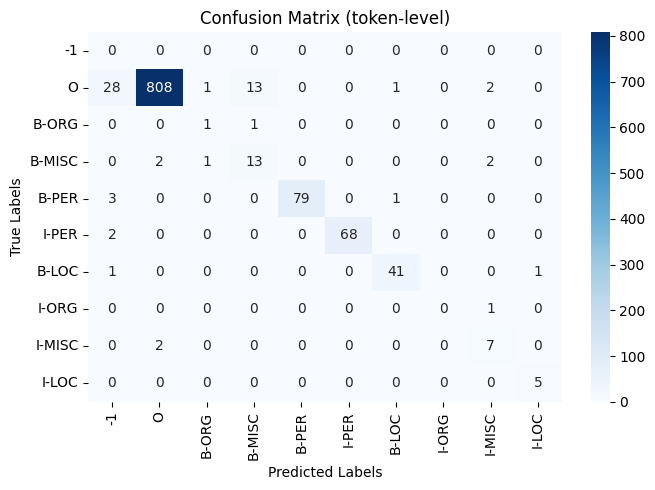

In [176]:
print("Vanilla Model performance:\n")
predicted_tags_V = predicted_tags_for_evaluation("Vanilla.json")
evaluate_ner(predicted_tags_V)

## Basic Decomposed QA Model performance

Basic Decomposed QA Model performance:

Token-Level Accuracy: 0.936

Classification Report (token-level):

              precision    recall  f1-score   support

           0      0.993     0.945     0.968       853
           1      0.182     1.000     0.308         2
           2      0.235     0.444     0.308        18
           3      0.964     0.976     0.970        83
           4      0.909     1.000     0.952        70
           5      0.884     0.884     0.884        43
           6      0.333     1.000     0.500         1
           7      0.357     0.556     0.435         9
           8      0.667     0.800     0.727         5

    accuracy                          0.936      1084
   macro avg      0.614     0.845     0.672      1084
weighted avg      0.959     0.936     0.946      1084



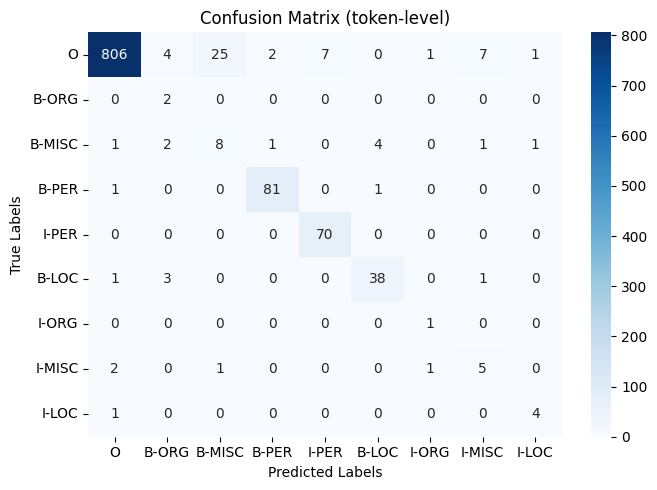

In [177]:
print("Basic Decomposed QA Model performance:\n")
predicted_tags_BDQA = predicted_tags_for_evaluation("Decomposed_QA.json")
evaluate_ner(predicted_tags_BDQA)

## Tool Augmentation Model performances

Tool Augmentation Model performance:

Token-Level Accuracy: 0.733

Classification Report (token-level):

              precision    recall  f1-score   support

          -1      0.000     0.000     0.000         0
           0      0.807     0.897     0.850       853
           1      0.000     0.000     0.000         2
           2      0.267     0.222     0.242        18
           3      0.875     0.084     0.154        83
           4      0.667     0.057     0.105        70
           5      0.786     0.256     0.386        43
           6      0.000     0.000     0.000         1
           7      0.667     0.222     0.333         9
           8      0.333     0.400     0.364         5

    accuracy                          0.733      1084
   macro avg      0.440     0.214     0.243      1084
weighted avg      0.788     0.733     0.711      1084



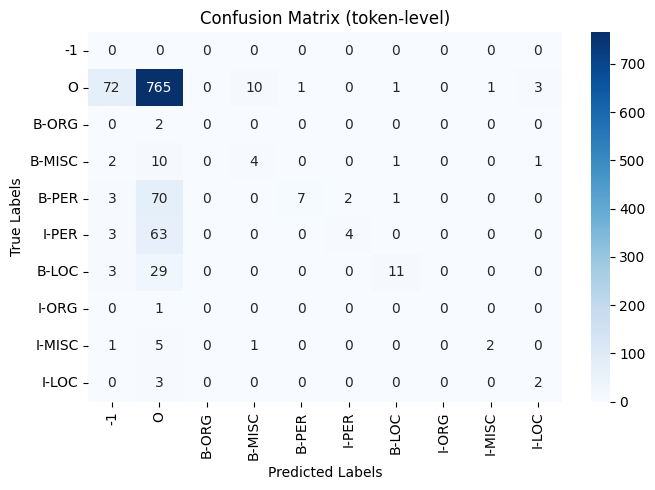

In [178]:
print("Tool Augmentation Model performance:\n")
predicted_tags_TA = predicted_tags_for_evaluation("Tool_Augmentation.json")
evaluate_ner(predicted_tags_TA)

#Multi-Agent Prompting Evalutation

Token-Level Accuracy: 0.708

Classification Report (token-level):

              precision    recall  f1-score   support

          -1      0.000     0.000     0.000         0
           0      1.000     0.764     0.866       853
           1      0.667     1.000     0.800         2
           2      0.588     0.556     0.571        18
           3      1.000     0.373     0.544        83
           4      1.000     0.257     0.409        70
           5      0.854     0.953     0.901        43
           6      0.500     1.000     0.667         1
           7      0.636     0.778     0.700         9
           8      0.833     1.000     0.909         5

    accuracy                          0.708      1084
   macro avg      0.708     0.668     0.637      1084
weighted avg      0.983     0.708     0.807      1084



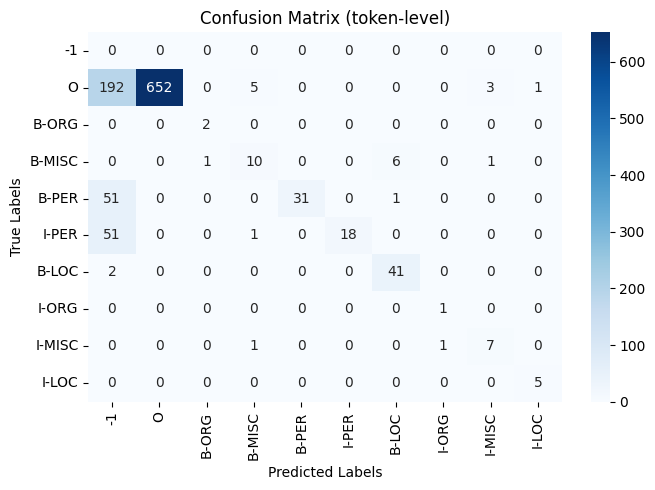

In [179]:
with open('ner_eval_data_ARBITER.json') as f:
    eval_data = json.load(f)

pred_list = []

for sample in eval_data['predicted_tags']:
    numeric_sample = []
    for label in sample:
        if label in feature_names:
            numeric_sample.append(feature_names[str(label)])
        else:
            if "none" in str(label).lower() or label==0 or "0" in str(label) or str(label).lower()=="o" or str(label) == "" or label==None:
              numeric_sample.append(0)
            else:
              numeric_sample.append(-1) # Means parsed wrong or with size different from the original token list
    pred_list.append(numeric_sample)

evaluate_ner(pred_list)

#Conclusions and final discussion

###Methods from the paper

The methods derived from the paper of interest demonstrated quite promising performance. In particular, we observed that the BIO tags associated with the "Miscellaneous" label were more challenging to predict accurately. The model often tagged words as "Miscellaneous" when they were not, and conversely failed to tag words as "Miscellaneous" when it would have been correct.

We concluded that these errors stemmed from the nature of the "Miscellaneous" class, which appears to require contextual understanding related to the topic of the miscellanea. For example, in the dataset used, the labels B-MISC or I-MISC were applied to words like "British," "German," and "Greek," but not consistently. This inconsistency made it difficult to provide the model with clear directives for identifying such instances.

Nonetheless, the performance for the other labels was sufficiently good—particularly with the Vanilla Method. We believe it outperformed the others because its prompting is simpler and less prone to parsing errors. In contrast, the other methods exhibited some issues due to incorrect parsing of the JSON files during execution.

As mentioned earlier, overall performance depends on the selected dataset and could potentially improve if the elements categorized as "Miscellaneous" were more clearly defined.<br>

For what concerns the prompting, we noticed that a good prompting technique was essential for the model to answer properly.

In fact, imposing too many constraints often led to outputs that were well-organized but overly limited or incorrect, with the model sometimes omitting key information. This was likely due to the excessive number of constraints placed on the output format.


<br><br>
###Multi-Agent Prompting

It was very interesting to observe the results and behavior of the method we proposed, but we are fully aware of its limitations. One major issue is the high computational complexity introduced by the architecture: performing three separate API calls per sentence significantly increases inference time and resource usage. In addition, the length of the responses grows considerably. Unlike standard approaches that only return entity predictions, our method requires detailed analysis and explanation for each decision, which increases both output size and processing difficulty.

One of the most critical problems we encountered was related to parsing the model’s output in JSON format. Especially when using smaller language models than the final one adopted, syntax errors in the JSON structure were frequent, such as missing commas, unclosed brackets, or malformed objects. These errors were handled conservatively: if the JSON was invalid, we marked all the tokens in that sentence as incorrect. This strict strategy negatively impacted overall NER performance and contributes to the gap with more robust baselines.

